Adapted from https://github.com/pumpikano/tf-dann

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from flip_gradient import flip_gradient
from keras.layers import Input, concatenate, Conv3D, MaxPooling3D, Conv3DTranspose, Flatten, Dense

import os
from tensorflow import set_random_seed
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
set_random_seed(3)
np.random.seed(3)

%matplotlib inline

import pickle as pkl
from sklearn.metrics import f1_score, accuracy_score
from keras import backend as K

from utils import *

import random
import statistics

/export/share/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
params = {'model': 'Unet_6',
          'training_mode': 'dann', # source, target or dann
          'mu0': 1e-2,
          'alpha': 10,
          'beta': 1,
          'p1': 0.2,
          'p2': 0.7,
          'l_max': 3,
          'lambda': 0,
         'num_steps': int(1e4),
         'batch_size': 4,
         'n_feat_maps': 16,
         'psi': 0.01,
         'fc': 'cnn'}
dest_dir = 'results'
save_session = False

In [3]:
model_X = tf.placeholder(tf.uint8, [None, 40, 40, 32, 1])
model_y = tf.placeholder(tf.float32, [None, 40, 40, 32])
model_domain = tf.placeholder(tf.float32, [None, 2])
model_l = tf.placeholder(tf.float32, [])
model_train = tf.placeholder(tf.bool, [])
        
pixel_mean = 86.62597169503347
pixel_std = 15.921692390390666
X_input = (tf.cast(model_X, tf.float32) - pixel_mean) / pixel_std
        
# Downsampling
        
inputs = X_input
conv1 = Conv3D(params['n_feat_maps'], (3, 3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv3D(params['n_feat_maps'], (3, 3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

conv2 = Conv3D(params['n_feat_maps'] * 2, (3, 3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv3D(params['n_feat_maps'] * 2, (3, 3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

conv3 = Conv3D(params['n_feat_maps'] * 4, (3, 3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv3D(params['n_feat_maps'] * 4, (3, 3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
        
# Bottleneck and feature extractor

conv4 = Conv3D(params['n_feat_maps'] * 8, (3, 3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv3D(params['n_feat_maps'] * 8, (3, 3, 3), activation='relu', padding='same')(conv4)
              
# Upsampling
        
copy3 = conv3
up5 = concatenate(
            [Conv3DTranspose(params['n_feat_maps'] * 4, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv4), copy3],
            axis=4)
conv5 = Conv3D(params['n_feat_maps'] * 4, (3, 3, 3), activation='relu', padding='same')(up5)
conv5 = Conv3D(params['n_feat_maps'] * 4, (3, 3, 3), activation='relu', padding='same')(conv5)
        
copy2 = conv2
up6 = concatenate(
            [Conv3DTranspose(params['n_feat_maps'] * 2, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv5), copy2],
            axis=4)
conv6 = Conv3D(params['n_feat_maps'] * 2, (3, 3, 3), activation='relu', padding='same')(up6)
conv6 = Conv3D(params['n_feat_maps'] * 2, (3, 3, 3), activation='relu', padding='same')(conv6)
model_feature = conv6
conv6_all = lambda: conv6
conv6_source = lambda: tf.slice(conv6, [0,0,0,0, 0], [params['batch_size']//2, 20,20, 16, params['n_feat_maps'] * 2])
conv6 = tf.cond(model_train, conv6_source, conv6_all)

copy1_all = lambda: conv1
copy1_source = lambda: tf.slice(conv1, [0,0,0,0, 0], [params['batch_size']//2, 40, 40, 32, params['n_feat_maps'] * 1])
copy1 = tf.cond(model_train, copy1_source, copy1_all)
up7 = concatenate(
            [Conv3DTranspose(params['n_feat_maps'] * 1, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv6), copy1],
            axis=4)
conv7 = Conv3D(params['n_feat_maps'] * 1, (3, 3, 3), activation='relu', padding='same')(up7)
conv7 = Conv3D(params['n_feat_maps'] * 1, (3, 3, 3), activation='relu', padding='same')(conv7)

conv8 = Conv3D(1, (1,1,1))(conv7)
        
# === Label predictor ===
        
all_labels = lambda: model_y
source_labels = lambda: tf.slice(model_y, [0,0,0, 0], [params['batch_size']//2, 40, 40, 32])
model_classify_labels = tf.cond(model_train, source_labels, all_labels)
            
logits = tf.squeeze(conv8)
model_pred = tf.nn.sigmoid(logits)
        
model_pred_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=model_classify_labels)

# === Domain classifier ===
        
feat = flip_gradient(model_feature, model_l)
            
convA = Conv3D(100, (3,3,3), activation='relu')(feat)
convA = Conv3D(100,(3,3,3), activation='relu')(convA)
poolA = MaxPooling3D((2,2,2))(convA)
convB = Conv3D(100,(3,3,3), activation='relu')(poolA)
convB = Conv3D(100,(3,3,3), activation='relu')(convB)
fl = Flatten()(convB)
dense = Dense(100, activation='relu')(fl)
d_logits = Dense(2)(dense)
            
model_domain_pred = tf.nn.softmax(d_logits)
model_domain_loss = tf.nn.softmax_cross_entropy_with_logits(logits=d_logits, labels=model_domain)

In [4]:
graph = tf.get_default_graph()
with graph.as_default():
    learning_rate = tf.placeholder(tf.float32, [])
    
    pred_loss = tf.reduce_mean(model_pred_loss)
    domain_loss = tf.reduce_mean(model_domain_loss)
    total_loss = pred_loss + params['psi']*domain_loss

    regular_train_op = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(pred_loss)
    dann_train_op = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(total_loss)
    
    # Evaluation
    correct_label_pred = tf.equal(K.flatten(model_classify_labels), tf.cast(tf.greater(K.flatten(model_pred), 0.5), tf.float32))
    label_acc = tf.reduce_mean(tf.cast(correct_label_pred, tf.float32))
    correct_domain_pred = tf.equal(tf.argmax(model_domain, 1), tf.argmax(model_domain_pred, 1))
    domain_acc = tf.reduce_mean(tf.cast(correct_domain_pred, tf.float32))

In [5]:
saver = tf.train.Saver()
verbose = 1
training_mode = params['training_mode']
with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()

    filenames = ['ct_train_'+str(ind) for ind in range(30)]
    gen_source_only_batch_train = batch_generator_files(filenames, params['batch_size'], shuffle=True)
    gen_source_batch_train = batch_generator_files(filenames, params['batch_size'] // 2, shuffle=True)

    filenames = ['ct_test_'+str(ind) for ind in range(30)]
    gen_source_only_batch_test = batch_generator_files(filenames, params['batch_size'], shuffle=False)
    gen_source_batch_test = batch_generator_files(filenames, params['batch_size'] // 2, shuffle=False)

    filenames = ['cbct_train_'+str(ind) for ind in range(30)]
    gen_target_only_batch_train = batch_generator_files(filenames, params['batch_size'], shuffle=True)
    gen_target_batch_train = batch_generator_files(filenames, params['batch_size'] // 2, shuffle=True)

    filenames = ['cbct_test_'+str(ind) for ind in range(30)]
    gen_target_only_batch_test = batch_generator_files(filenames, params['batch_size'], shuffle=False)
    gen_target_batch_test = batch_generator_files(filenames, params['batch_size'] // 2, shuffle=False)

    domain_labels = np.vstack([np.tile([1., 0.], [params['batch_size'] // 2, 1]),
                               np.tile([0., 1.], [params['batch_size'] // 2, 1])])

    total_dice_dann = []
    total_dice_source = []
    total_dice_target = []
    
    total_original_images_dann = []
    total_original_masks_dann = []
    total_pred_masks_dann = []
    
    total_original_images_source = []
    total_original_masks_source = []
    total_pred_masks_source = []
    
    total_original_images_target = []
    total_original_masks_target = []
    total_pred_masks_target = []
    
    mydict = {'loss': np.zeros(params['num_steps']),
           'd_acc': np.zeros(params['num_steps']),
           'p_acc': np.zeros(params['num_steps']),
           'l': np.zeros(params['num_steps']),
           'dloss': np.zeros(params['num_steps']),
           'ploss': np.zeros(params['num_steps']),
             'd_acc_test': np.zeros(int(params['num_steps']/100)),
              'd_acc_train': np.zeros(int(params['num_steps']/100)),
              'tloss_train': np.zeros(int(params['num_steps']/100)),
              'dice_ct_train': np.zeros(int(params['num_steps']/100)),
             'dice_ct_test': np.zeros(int(params['num_steps']/100)),
             'dice_cbct_train': np.zeros(int(params['num_steps']/100)),
             'dice_cbct_test': np.zeros(int(params['num_steps']/100)),
             'loss_smooth': np.zeros(int(params['num_steps']/100)),
             'pred_loss_train': np.zeros(int(params['num_steps']/100)),
             'pred_loss_test': np.zeros(int(params['num_steps']/100)),
             'domain_loss_train': np.zeros(int(params['num_steps']/100)),
             'domain_loss_test': np.zeros(int(params['num_steps']/100))}

    # Training loop. i is the index for every step. k is the index for the step for which we print results
    for i in range(params['num_steps']):

        # Adaptation param and learning rate schedule as described in the paper
        p = float(i) / params['num_steps']
        if 'lambda' in params.keys():
            l = params['lambda']
        elif 'p1' in params.keys() and 'p2' in params.keys() and 'l_max' in params.keys():
            l = params['l_max']*np.clip((p-params['p1'])/(params['p2']-params['p1']), 0., 1.)
        else:
            l = 2. / (1. + np.exp(-params['gamma'] * p)) - 1
        lr = params['mu0'] / (1. + params['alpha'] * p)**params['beta']

        if training_mode == 'source':
            X, y = next(gen_source_only_batch_train)
            _, batch_loss = sess.run([regular_train_op, pred_loss],
                                 feed_dict={model_X: X, model_y: y, model_train: False,
                                            model_l: l, learning_rate: lr})

        elif training_mode == 'target':
            X, y = next(gen_target_only_batch_train)
            _, batch_loss = sess.run([regular_train_op, pred_loss],
                                 feed_dict={model_X: X, model_y: y, model_train: False,
                                            model_l: l, learning_rate: lr})

        # Training step
        elif training_mode == 'dann':
            X0, y0 = next(gen_source_batch_train)
            X1, y1 = next(gen_target_batch_train)
            X = np.vstack([X0, X1])
            y = np.vstack([y0, y1])

            _, batch_loss, dloss, ploss, d_acc, p_acc = sess.run(
                [dann_train_op, total_loss, domain_loss, pred_loss, domain_acc, label_acc],
                feed_dict={model_X: X, model_y: y, model_domain: domain_labels,
                           model_train: True, model_l: l, learning_rate: lr})

        if verbose and i % 100 == 0:
            mydict['l'][i//100] = l
            n_batches = 30//params['batch_size']
            pred_loss_train = 0
            domain_loss_train = 0
            pred_loss_test = 0
            domain_loss_test = 0
            d_acc_train = 0
            loss_test = 0
            d_acc_test = 0
            loss_smooth = 0

            # loss_train and d_acc_train
            if training_mode=='dann':
                for _ in range(2*n_batches):
                    X0, y0 = next(gen_source_batch_train)
                    X1, y1 = next(gen_target_batch_train)
                    X = np.vstack([X0, X1])
                    y = np.vstack([y0, y1])
                    pred_loss_batch, domain_loss_batch, d_acc_batch = sess.run([pred_loss, domain_loss, domain_acc],
                            feed_dict={model_X: X, model_y: y, model_domain: domain_labels,
                           model_train: True})
                    pred_loss_train += pred_loss_batch
                    domain_loss_train += domain_loss_batch
                    d_acc_train += d_acc_batch
                mydict['pred_loss_train'][i//100] = pred_loss_train/(2*n_batches)
                mydict['domain_loss_train'][i//100] = domain_loss_train/(2*n_batches)
                mydict['d_acc_train'][i//100] = d_acc_train/(2*n_batches)

                # loss_test and d_acc_test
                for _ in range(2*n_batches):
                    X0, y0 = next(gen_source_batch_test)
                    X1, y1 = next(gen_target_batch_test)
                    X = np.vstack([X0, X1])
                    y = np.vstack([y0, y1])
                    pred_loss_batch, domain_loss_batch, d_acc_batch = sess.run([pred_loss, domain_loss, domain_acc],
                            feed_dict={model_X: X, model_y: y, model_domain: domain_labels,
                           model_train: True})
                    pred_loss_test += pred_loss_batch
                    domain_loss_test += domain_loss_batch
                    d_acc_test += d_acc_batch
                mydict['pred_loss_test'][i//100] = pred_loss_test/(2*n_batches)
                mydict['domain_loss_test'][i//100] = domain_loss_test/(2*n_batches)
                mydict['d_acc_test'][i//100] = d_acc_test/(2*n_batches)

            # dice_ct_train and loss_smooth
            dice_ct_train = 0
            for _ in range(n_batches):
                X_batch, y_batch = next(gen_source_only_batch_train)
                pred_batch = sess.run(model_pred, feed_dict={model_X: X_batch, model_train: False})
                if training_mode =='source':
                    loss_smooth += sess.run(pred_loss,feed_dict={model_X: X_batch, model_y: y_batch, model_train: False})
                pred_batch_thr = (pred_batch>0.5)
                for ind in range(params['batch_size']):
                        dice_ct_train += f1_score(y_batch[ind,:,:].flatten(), pred_batch_thr[ind,:,:].flatten())
            dice_ct_train = dice_ct_train/30
            mydict['dice_ct_train'][i//100] = dice_ct_train

            # dice_ct_test
            dice_ct_test = 0
            for _ in range(n_batches):
                X_batch, y_batch = next(gen_source_only_batch_test)
                #print('X_batch.shape', X_batch.shape)
                pred_batch = sess.run(model_pred, feed_dict={model_X: X_batch, model_train: False})
                pred_batch_thr = (pred_batch>0.5)
                #print('pred_batch_thr.shape', pred_batch_thr.shape)
                for ind in range(params['batch_size']):
                    dice_ct_test += f1_score(y_batch[ind,:,:].flatten(), pred_batch_thr[ind,:,:].flatten())
            dice_ct_test = dice_ct_test/30
            mydict['dice_ct_test'][i//100] = dice_ct_test

            # dice_cbct_train and loss_smooth
            dice_cbct_train = 0
            for b in range(n_batches):
                X_batch, y_batch = next(gen_target_only_batch_train)
                pred_batch = sess.run(model_pred, feed_dict={model_X: X_batch, model_train: False})
                if training_mode =='target':
                    loss_smooth += sess.run(pred_loss,feed_dict={model_X: X_batch, model_y: y_batch, model_train: False})
                pred_batch_thr = (pred_batch>0.5)
                for ind in range(params['batch_size']):
                    dice_cbct_train += f1_score(y_batch[ind,:,:].flatten(), pred_batch_thr[ind,:,:].flatten())
                    
            dice_cbct_train = dice_cbct_train/30
            mydict['dice_cbct_train'][i//100] = dice_cbct_train

            # dice_cbct_test
            dice_cbct_test = 0
            for _ in range(n_batches):
                X_batch, y_batch = next(gen_target_only_batch_test)
                pred_batch = sess.run(model_pred, feed_dict={model_X: X_batch, model_train: False})
                pred_batch_thr = (pred_batch>0.5)
                for ind in range(params['batch_size']):
                    dice_cbct_test += f1_score(y_batch[ind,:,:].flatten(), pred_batch_thr[ind,:,:].flatten())
                    if i==(params['num_steps']-100):
                        temp_2 = f1_score(y_batch[ind,:,:].flatten(), pred_batch_thr[ind,:,:].flatten())
                        if training_mode=='dann':
                            total_dice_dann.append(temp_2)
                            total_original_images_dann.append(X_batch)
                            total_original_masks_dann.append(y_batch)
                            total_pred_masks_dann.append(pred_batch)
                        elif training_mode=='source':
                            total_dice_source.append(temp_2)
                            total_original_images_source.append(X_batch)
                            total_original_masks_source.append(y_batch)
                            total_pred_masks_source.append(pred_batch)
                        elif training_mode=='target':   
                            total_dice_target.append(temp_2)
                            total_original_images_target.append(X_batch)
                            total_original_masks_target.append(y_batch)
                            total_pred_masks_target.append(pred_batch)
                                                    
            dice_cbct_test = dice_cbct_test/30
            mydict['dice_cbct_test'][i//100] = dice_cbct_test

            loss_smooth = loss_smooth/n_batches
            mydict['loss_smooth'][i//100] = loss_smooth

            if training_mode=='source' or training_mode=='target':
                print('Step {}/{} - loss: {} - dice_ct_train: {} - dice_ct_test: {} - dice_cbct_train: {} - dice_cbct_test: {} - loss_smooth: {}'.format(i, params['num_steps'], batch_loss, dice_ct_train, dice_ct_test, dice_cbct_train, dice_cbct_test, loss_smooth))
            elif training_mode=='dann':
                print('Step {}/{} - pred_loss_train: {:.2e} - pred_loss_test: {:.2e} - domain_loss_train: {:.2e} - domain_loss_test: {:.2e} - loss_train: {:.2e} - loss_test: {:.2e} - d_acc_train: {:.2e} - d_acc_test: {:.2e}'.format(
                    i, params['num_steps'], 
                    mydict['pred_loss_train'][i//100], mydict['pred_loss_test'][i//100], 
                    mydict['domain_loss_train'][i//100], mydict['domain_loss_test'][i//100],
                    mydict['pred_loss_train'][i//100]+mydict['domain_loss_train'][i//100], mydict['pred_loss_test'][i//100]+mydict['domain_loss_test'][i//100],
                    mydict['d_acc_train'][i//100], mydict['d_acc_test'][i//100]))
                
            
            if i==(params['num_steps']-100) and save_session:
                print('saving')
                filepath = dest_dir + '/' + params2name(params) + '/model.ckpt'
                saver.save(sess, filepath)

        mydict['loss'][i] = batch_loss
    
        
    
    if not os.path.exists(dest_dir + '/' + params2name(params)):
        os.makedirs(dest_dir + '/' + params2name(params))
    filepath = dest_dir + '/' + params2name(params) + '/mydict.p'
    pkl.dump( mydict, open( filepath, 'wb' ) )
    
    


Step 0/10000 - pred_loss_train: 6.91e-01 - pred_loss_test: 6.90e-01 - domain_loss_train: 6.94e-01 - domain_loss_test: 6.94e-01 - loss_train: 1.38e+00 - loss_test: 1.38e+00 - d_acc_train: 4.64e-01 - d_acc_test: 3.39e-01


/export/share/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Step 100/10000 - pred_loss_train: 1.83e-01 - pred_loss_test: 1.85e-01 - domain_loss_train: 6.93e-01 - domain_loss_test: 6.93e-01 - loss_train: 8.75e-01 - loss_test: 8.79e-01 - d_acc_train: 5.36e-01 - d_acc_test: 4.29e-01
Step 200/10000 - pred_loss_train: 1.68e-01 - pred_loss_test: 1.64e-01 - domain_loss_train: 6.92e-01 - domain_loss_test: 6.93e-01 - loss_train: 8.59e-01 - loss_test: 8.57e-01 - d_acc_train: 5.54e-01 - d_acc_test: 5.54e-01
Step 300/10000 - pred_loss_train: 1.50e-01 - pred_loss_test: 1.41e-01 - domain_loss_train: 6.90e-01 - domain_loss_test: 6.92e-01 - loss_train: 8.40e-01 - loss_test: 8.32e-01 - d_acc_train: 6.25e-01 - d_acc_test: 5.36e-01
Step 400/10000 - pred_loss_train: 1.46e-01 - pred_loss_test: 1.27e-01 - domain_loss_train: 6.90e-01 - domain_loss_test: 6.91e-01 - loss_train: 8.36e-01 - loss_test: 8.18e-01 - d_acc_train: 6.07e-01 - d_acc_test: 5.36e-01
Step 500/10000 - pred_loss_train: 1.58e-01 - pred_loss_test: 1.32e-01 - domain_loss_train: 6.87e-01 - domain_loss_te

Step 3800/10000 - pred_loss_train: 1.72e-02 - pred_loss_test: 2.75e-02 - domain_loss_train: 3.61e-01 - domain_loss_test: 2.65e-01 - loss_train: 3.78e-01 - loss_test: 2.93e-01 - d_acc_train: 8.57e-01 - d_acc_test: 8.57e-01
Step 3900/10000 - pred_loss_train: 1.69e-02 - pred_loss_test: 2.59e-02 - domain_loss_train: 3.32e-01 - domain_loss_test: 3.14e-01 - loss_train: 3.49e-01 - loss_test: 3.40e-01 - d_acc_train: 7.86e-01 - d_acc_test: 8.21e-01
Step 4000/10000 - pred_loss_train: 1.89e-02 - pred_loss_test: 2.67e-02 - domain_loss_train: 3.18e-01 - domain_loss_test: 3.12e-01 - loss_train: 3.37e-01 - loss_test: 3.39e-01 - d_acc_train: 8.39e-01 - d_acc_test: 8.39e-01
Step 4100/10000 - pred_loss_train: 1.67e-02 - pred_loss_test: 2.71e-02 - domain_loss_train: 3.69e-01 - domain_loss_test: 3.04e-01 - loss_train: 3.85e-01 - loss_test: 3.31e-01 - d_acc_train: 7.86e-01 - d_acc_test: 8.21e-01
Step 4200/10000 - pred_loss_train: 1.69e-02 - pred_loss_test: 2.69e-02 - domain_loss_train: 3.15e-01 - domain_lo

Step 7500/10000 - pred_loss_train: 1.27e-02 - pred_loss_test: 2.56e-02 - domain_loss_train: 1.63e-01 - domain_loss_test: 2.92e-01 - loss_train: 1.76e-01 - loss_test: 3.18e-01 - d_acc_train: 9.46e-01 - d_acc_test: 8.21e-01
Step 7600/10000 - pred_loss_train: 1.21e-02 - pred_loss_test: 2.71e-02 - domain_loss_train: 1.58e-01 - domain_loss_test: 3.12e-01 - loss_train: 1.70e-01 - loss_test: 3.39e-01 - d_acc_train: 9.64e-01 - d_acc_test: 8.21e-01
Step 7700/10000 - pred_loss_train: 1.18e-02 - pred_loss_test: 2.62e-02 - domain_loss_train: 1.83e-01 - domain_loss_test: 2.99e-01 - loss_train: 1.95e-01 - loss_test: 3.25e-01 - d_acc_train: 9.29e-01 - d_acc_test: 8.21e-01
Step 7800/10000 - pred_loss_train: 1.37e-02 - pred_loss_test: 2.49e-02 - domain_loss_train: 1.47e-01 - domain_loss_test: 3.01e-01 - loss_train: 1.61e-01 - loss_test: 3.26e-01 - d_acc_train: 9.46e-01 - d_acc_test: 8.39e-01
Step 7900/10000 - pred_loss_train: 1.26e-02 - pred_loss_test: 2.49e-02 - domain_loss_train: 1.45e-01 - domain_lo

In [6]:
print(mydict['dice_cbct_test'][-1])

0.4674110364075427


In [7]:
filepath = '/home/cuxartgarcia/unet_uda_29-4-20/results/' + params2name(params) + '/mydict.p'
mydict = pkl.load( open( filepath, "rb" ) )

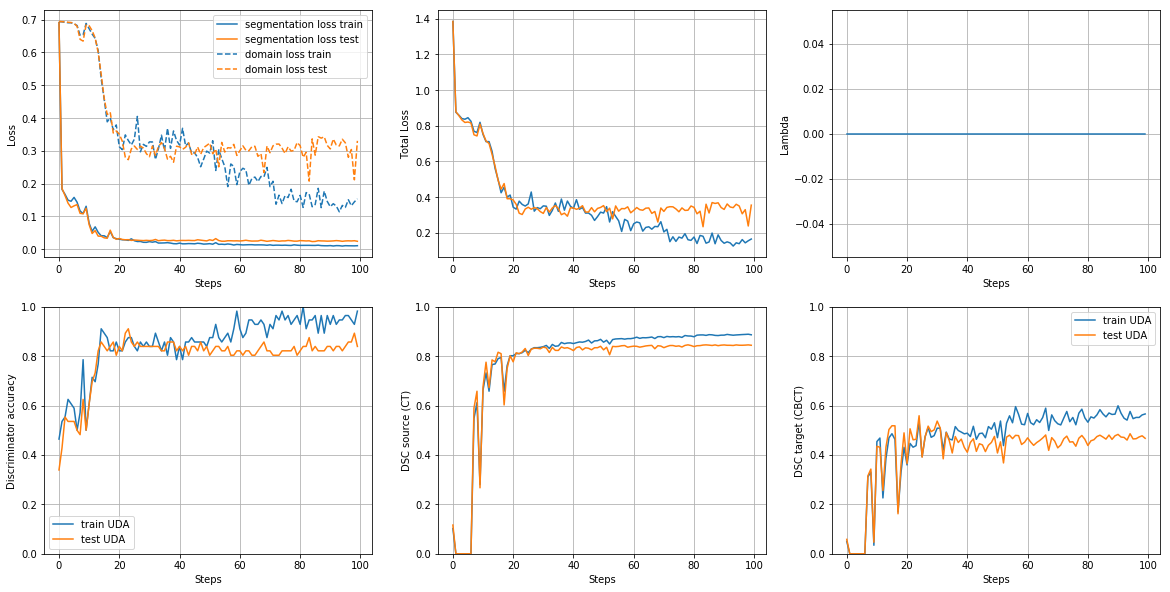

In [8]:
plt.figure(figsize=(20,10), frameon=False)

#plt.suptitle(params2name(params) + '\n \n' + 'dice_cbct_test=%.3f' % mydict['dice_cbct_test'][-1])



if training_mode=='source' or training_mode=='target':
    plt.subplot(2,3,1)
    plt.plot(mydict['loss_smooth'], color='#1f77b4', label='segmentation loss')
    plt.ylabel('Loss')
    plt.xlabel('Steps')
    plt.grid()
    plt.legend()
    
    plt.subplot(2,3,2)
    plt.plot(mydict['dice_ct_train'], label='train')
    plt.plot(mydict['dice_ct_test'], label='test')
    plt.ylabel('DSC source (CT)')
    plt.xlabel('Steps')
    plt.ylim([0,1])
    plt.legend()
    plt.grid()
    plt.subplot(2,3,3)
    plt.plot(mydict['dice_cbct_train'], color='#1f77b4', label='train')
    plt.plot(mydict['dice_cbct_test'], color='#ff7f0e', label='test')
    #plt.plot(mydict_disconnected['dice_cbct_train'], color='#1f77b4', linestyle='--', label='train, $\lambda=0$')
    #plt.plot(mydict_disconnected['dice_cbct_test'], color='#ff7f0e', linestyle='--', label='test, $\lambda=0$')
    plt.legend()
    plt.ylabel('DSC target (CBCT)')
    plt.xlabel('Steps')
    plt.ylim([0,1])
    plt.grid()


else:
    plt.subplot(2,3,1)
    plt.plot(mydict['pred_loss_train'], color='#1f77b4', label='segmentation loss train')
    plt.plot(mydict['pred_loss_test'], color='#ff7f0e', label='segmentation loss test')
    plt.plot(mydict['domain_loss_train'], color='#1f77b4', linestyle='--', label='domain loss train')
    plt.plot(mydict['domain_loss_test'], color='#ff7f0e', linestyle='--', label='domain loss test')
    plt.ylabel('Loss')
    plt.xlabel('Steps')
    plt.grid()
    plt.legend()


    plt.subplot(2,3,2)
    y = [mydict['pred_loss_train'][i]+mydict['domain_loss_train'][i] for i in range(params['num_steps']//100)]
    plt.plot(y)
    y = [mydict['pred_loss_test'][i]+mydict['domain_loss_test'][i] for i in range(params['num_steps']//100)]
    plt.plot(y)
    plt.ylabel('Total Loss')
    plt.xlabel('Steps')
    plt.grid()

    plt.subplot(2,3,3)
    plt.plot(mydict['l'][:params['num_steps']//100])
    plt.ylabel('Lambda')
    plt.grid()
    plt.xlabel('Steps')

    plt.subplot(2,3,4)
    plt.plot(mydict['d_acc_train'], color='#1f77b4', label='train UDA')
    plt.plot(mydict['d_acc_test'], color='#ff7f0e', label='test UDA')
    #plt.plot(mydict_disconnected['d_acc_train'], color='#1f77b4', linestyle='--', label='train, $\lambda=0$')
    #plt.plot(mydict_disconnected['d_acc_test'], color='#ff7f0e', linestyle='--', label='domain, $\lambda=0$')


    plt.ylabel('Discriminator accuracy')
    plt.ylim([0,1])
    plt.xlabel('Steps')
    plt.grid()
    plt.legend()
    plt.subplot(2,3,5)
    plt.plot(mydict['dice_ct_train'])
    plt.plot(mydict['dice_ct_test'])
    plt.ylabel('DSC source (CT)')
    plt.ylim([0,1])
    plt.xlabel('Steps')
    plt.grid()
    plt.subplot(2,3,6)
    plt.plot(mydict['dice_cbct_train'], color='#1f77b4', label='train UDA')
    plt.plot(mydict['dice_cbct_test'], color='#ff7f0e', label='test UDA')
    #plt.plot(mydict_disconnected['dice_cbct_train'], color='#1f77b4', linestyle='--', label='train, $\lambda=0$')
    #plt.plot(mydict_disconnected['dice_cbct_test'], color='#ff7f0e', linestyle='--', label='test, $\lambda=0$')
    plt.legend()
    plt.ylabel('DSC target (CBCT)')
    plt.ylim([0,1])
    plt.xlabel('Steps')
    plt.grid()

filepath = '/home/cuxartgarcia/unet_uda_29-4-20/results/' + params2name(params) + '/learning_curves.eps'
plt.savefig(filepath)

## DICE CBCT standard deviation

### DANN

In [7]:
print(mydict['dice_cbct_test'][-1])
print(statistics.stdev(total_dice_dann))

0.6234694285602739
0.14920013537284296


### SOURCE

In [9]:
print(mydict['dice_cbct_test'][-1])
print(statistics.stdev(total_dice_source))

0.38387505589289994
0.2699068305891889


### TARGET

In [7]:
print(mydict['dice_cbct_test'][-1])
print(statistics.stdev(total_dice_target))

0.7171962459427715
0.17796294226101503


## BOXPLOT 

In [9]:
import matplotlib as mpl 
mpl.use('agg')  ## agg backend is used to create plot as a .png file

import matplotlib.pyplot as plt 

dice_test_dann = [0.7518632178868917, 0.4478554009467795, 0.8369938741969221, 0.7940204110967372, 0.748160969277369, 0.6371571072319202, 0.6540832049306626, 0.4492020241339042, 0.5339908418457203, 0.34184882802212274, 0.8313181367690782, 0.7165651290977662, 0.7824333408021511, 0.8271036012971497, 0.7589251439539347, 0.7488648271044359, 0.7918570835064396, 0.7691029900332226, 0.4565640825866771, 0.7705163916863083, 0.7146087743102668, 0.6922183507549362, 0.4857842214272265, 0.8448604060913705, 0.6000000000000001, 0.6228513650151669, 0.8465991316931983, 0.7154178674351584]
dice_test_source = [0.4287464271131074, 0.5024533856722276, 0.2704678362573099, 0.3175065540343723, 0.18020417221482468, 0.3817797605071613, 0.29574531389467423, 0.45329849771391245, 0.0, 0.060209424083769635, 0.8089775561097257, 0.49978041282389113, 0.8151823368891095, 0.8450143709927039, 0.4482481947044664, 0.7816, 0.8249660786974219, 0.47719470328592445, 0.3490280777537797, 0.6582518144525087, 0.6550137994480222, 0.13557358053302435, 0.5912627169359664, 0.10837988826815644, 0.35909980430528377, 0.34177215189873417, 0.5935733002344504, 0.018469656992084433]
dice_test_target =[0.8969603297269448, 0.8291267769074557, 0.9245435016111708, 0.90529638723255, 0.8690559850081986, 0.9011957205789806, 0.7997107736804049, 0.8337662337662337, 0.7581989994441357, 0.0, 0.853318250377074, 0.7982289690069575, 0.7352721849366144, 0.8780867198133385, 0.8519440124416796, 0.6709970769730432, 0.5979438732981384, 0.900197806149973, 0.6008037508372404, 0.8248407643312102, 0.749597423510467, 0.8494208494208495, 0.6276958002270148, 0.7964570416297608, 0.7294117647058823, 0.6502963590177815, 0.9092743970128166, 0.7766575007638252]

## combine these different collections into a list    
test = [dice_test_source, dice_test_target, dice_test_dann]

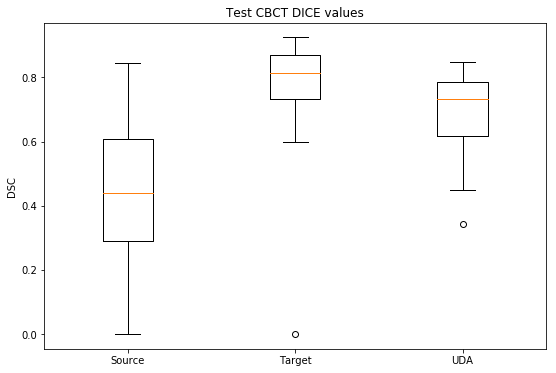

In [11]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(test)
ax.set_xticklabels(['Source', 'Target', 'UDA'])
ax.set_ylabel('DSC')
plt.title('Test CBCT DICE values')

# Save the figure
fig.savefig('dice_test.eps', bbox_inches='tight')
## Custom x-axis labels

## Table of results

## Contours and distances

In [14]:
import imageio
import cv2
from scipy.misc import toimage, imsave
from PIL import Image
from scipy.spatial.distance import cdist
from scipy.misc import imfilter

slice_num = 5
organ_num = 0
spacing = [4.8, 4.8, 6]
metrics = {}



def mask2contours(mask):
    sh = mask.shape
    contours = np.zeros((sh[0],sh[1],sh[2]))
    n_slices = sh[2]
    
    for s in range(n_slices):
        if s>0 and np.sum(mask[:,:,s-1].flatten())==0:
            contours[:,:,s] = mask[:,:,s]
        
        elif s<(n_slices-1) and np.sum(mask[:,:,s+1].flatten())==0:
            contours[:,:,s] = mask[:,:,s]
        else:
            diff = np.abs(mask[:,:,s]*1 - mask[:,:,s-1]*1)>0
            imf = imfilter(mask[:,:,s].astype('int'), 'find_edges')
            if np.sum(diff.flatten()>0):
                contours[:,:,s] = (diff+imf)>0
            else:
                contours[:, :, s] = imf
    return contours

## SOURCE

0
1
2
3
4
14
0.42905280205129404
0.4581005586592179


/export/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/export/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/export/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/export/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `imfilter` is deprecated!
`imfilter` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow filtering functionality directly.


[164.34305583]
[60.10790297]
[30.95089131]


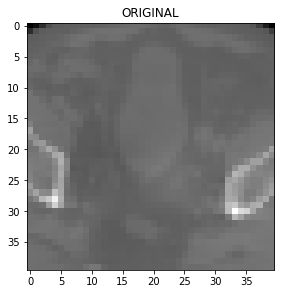

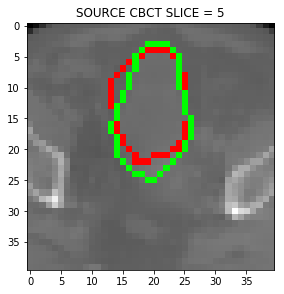

In [21]:
index = (np.abs(total_dice_source-dice_cbct_test)).argmin()
closests_index = 
# Find 5 closest to mean
for indexx in range(5):
    print (indexx)






print(index)
print(dice_cbct_test)
print(total_dice_source[index])

# Save np images as .png
imsave("./closest_pred_mask_source.png".format(), total_pred_masks_source[index][organ_num,:,:,slice_num])
imsave("./closest_pred_image_source.png".format(), total_original_images_source[index][organ_num,:,:,slice_num,0])
imsave("./closest_original_mask_source.png".format(), total_original_masks_source[index][organ_num,:,:,slice_num])

image_original = cv2.imread("closest_pred_image_source.png")


# Prepare contours ORIGINAL MASK
mask_original = cv2.imread("closest_original_mask_source.png")
gray_image_original_mask = cv2.cvtColor(mask_original, cv2.COLOR_BGR2GRAY)

# Apply cv2.threshold() to get a binary image
ret, thresh = cv2.threshold(gray_image_original_mask, 50, 255, cv2.THRESH_BINARY)

# Find contours:
im, contours_original, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)


# Prepare contours PREDICTED MASK
mask_pred = cv2.imread("closest_pred_mask_source.png")
gray_image_pred_mask = cv2.cvtColor(mask_pred, cv2.COLOR_BGR2GRAY)

# Apply cv2.threshold() to get a binary image
ret, thresh = cv2.threshold(gray_image_pred_mask, 50, 255, cv2.THRESH_BINARY)

# Find contours:
im, contours_pred, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Show image:
plt.figure(figsize=(20,10), frameon=False)
plt.subplot(2,2,2)
plt.title('ORIGINAL')
plt.imshow(image_original)

plt.savefig('final_ORIGINAL_source_'+str(slice_num)+'_'+str(total_dice_source[index])+str(index)+'.eps', bbox_inches='tight')


# Draw contours:
cv2.drawContours(image_original, contours_pred, 0, (255, 0, 0), 1)
cv2.drawContours(image_original, contours_original, 0, (0, 255, 0), 1)

# Show image:
plt.figure(figsize=(20,10), frameon=False)
plt.subplot(2,2,3)
plt.title('SOURCE CBCT SLICE = '+str(slice_num))
plt.imshow(image_original)

#Compute distance
metrics['HDs'] = np.zeros(1)
metrics['HD95s'] = np.zeros(1)
metrics['HDmeans'] = np.zeros(1)

pred_contours = mask2contours(total_pred_masks_source[index][organ_num,:,:,:])
mask_contours = mask2contours(total_original_masks_source[index][organ_num,:,:,:])
coord1 = np.argwhere(mask_contours)*np.asarray(spacing)
coord2 = np.argwhere(pred_contours)*np.asarray(spacing)
Y = cdist(coord1,coord2)
if Y.shape[1]>0:
    DAB = np.min(Y,axis=1)
    DBA = np.min(Y,axis=0)
    metrics['HDs'][organ_num] = np.max([np.max(DAB), np.max(DBA)])
    metrics['HD95s'][organ_num] = np.mean([np.percentile(DAB, 95), np.percentile(DBA, 95)])
    metrics['HDmeans'][organ_num] = np.mean([np.mean(DAB), np.mean(DBA)])
else:
    metrics['HDs'][organ_num] = None
    metrics['HD95s'][organ_num] = None
    metrics['HDmeans'][organ_num] = None

print( metrics['HDs'])
print( metrics['HD95s'])
print( metrics['HDmeans'])


# Save the figure
plt.savefig('final_CBCT_source_'+str(slice_num)+'_'+str(total_dice_source[index])+'_'+str(metrics['HDmeans'])+str(index)+'.eps', bbox_inches='tight')


## TARGET

[0.8927824267782427, 0.8444857496902107, 0.9254173397953688, 0.9003783102143758, 0.8707998106956933, 0.8791492104415082, 0.7883495145631068, 0.7912687585266029, 0.7673060884070059, 0.0, 0.8637659129773894, 0.7856462369006033, 0.7370998116760829, 0.870854467420991, 0.8606465997770345, 0.7048846675712348, 0.650401482396541, 0.8921568627450981, 0.5771720613287905, 0.8224299065420559, 0.7318563789152024, 0.8119249171880751, 0.6300114547537227, 0.7847421203438395, 0.7188742734781279, 0.609225413402959, 0.9023485784919654, 0.7830559757942511]
12
0.7370998116760829


/export/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  
/export/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  if __name__ == '__main__':
/export/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  # Remove the CWD from sys.path while we load stuff.
/export/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `imfilter` is deprecated!
`imfilter` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow filtering functionality directly.


[164.34305583]
[59.97899632]
[31.17454506]


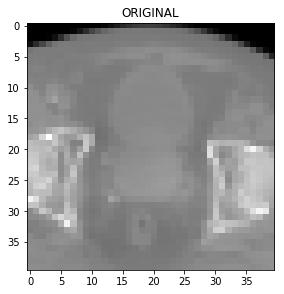

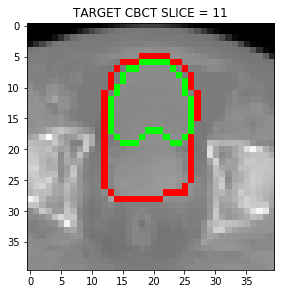

In [25]:
index = (np.abs(total_dice_target-dice_cbct_test)).argmin()
index = 12
print(total_dice_target)
print(index)
print(total_dice_target[index])

# Save np images as .png
imsave("./closest_pred_mask_target.png".format(), total_pred_masks_target[index][organ_num,:,:,slice_num])
imsave("./closest_pred_image_target.png".format(), total_original_images_target[index][organ_num,:,:,slice_num,0])
imsave("./closest_original_mask_target.png".format(), total_original_masks_target[index][organ_num,:,:,slice_num])

image_original = cv2.imread("closest_pred_image_target.png")


# Prepare contours ORIGINAL MASK
mask_original = cv2.imread("closest_original_mask_target.png")
gray_image_original_mask = cv2.cvtColor(mask_original, cv2.COLOR_BGR2GRAY)

# Apply cv2.threshold() to get a binary image
ret, thresh = cv2.threshold(gray_image_original_mask, 50, 255, cv2.THRESH_BINARY)

# Find contours:
im, contours_original, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)


# Prepare contours PREDICTED MASK
mask_pred = cv2.imread("closest_pred_mask_target.png")
gray_image_pred_mask = cv2.cvtColor(mask_pred, cv2.COLOR_BGR2GRAY)

# Apply cv2.threshold() to get a binary image
ret, thresh = cv2.threshold(gray_image_pred_mask, 50, 255, cv2.THRESH_BINARY)

# Find contours:
im, contours_pred, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Show image:
plt.figure(figsize=(20,10), frameon=False)
plt.subplot(2,2,2)
plt.title('ORIGINAL')
plt.imshow(image_original)

plt.savefig('final_ORIGINAL_target_'+str(slice_num)+'_'+str(total_dice_target[index])+str(index)+'.eps', bbox_inches='tight')


# Draw contours:
cv2.drawContours(image_original, contours_pred, 0, (255, 0, 0), 1)
cv2.drawContours(image_original, contours_original, 0, (0, 255, 0), 1)

# Show image:
plt.figure(figsize=(20,10), frameon=False)
plt.subplot(2,2,3)
plt.title('TARGET CBCT SLICE = '+str(slice_num))
plt.imshow(image_original)

#Compute distance
metrics['HDs'] = np.zeros(1)
metrics['HD95s'] = np.zeros(1)
metrics['HDmeans'] = np.zeros(1)

pred_contours = mask2contours(total_pred_masks_target[index][organ_num,:,:,:])
mask_contours = mask2contours(total_original_masks_target[index][organ_num,:,:,:])
coord1 = np.argwhere(mask_contours)*np.asarray(spacing)
coord2 = np.argwhere(pred_contours)*np.asarray(spacing)
Y = cdist(coord1,coord2)
if Y.shape[1]>0:
    DAB = np.min(Y,axis=1)
    DBA = np.min(Y,axis=0)
    metrics['HDs'][organ_num] = np.max([np.max(DAB), np.max(DBA)])
    metrics['HD95s'][organ_num] = np.mean([np.percentile(DAB, 95), np.percentile(DBA, 95)])
    metrics['HDmeans'][organ_num] = np.mean([np.mean(DAB), np.mean(DBA)])
else:
    metrics['HDs'][organ_num] = None
    metrics['HD95s'][organ_num] = None
    metrics['HDmeans'][organ_num] = None

print( metrics['HDs'])
print( metrics['HD95s'])
print( metrics['HDmeans'])


# Save the figure
plt.savefig('final_CBCT_target_'+str(slice_num)+'_'+str(total_dice_target[index])+'_'+str(metrics['HDmeans'])+str(index)+'.eps', bbox_inches='tight')



## UDA

In [ ]:
index = (np.abs(total_dice_dann-dice_cbct_test)).argmin()
print(total_dice_dann[index])

# Save np images as .png
imsave("./closest_pred_mask_dann.png".format(), total_pred_masks_dann[index][organ_num,:,:,slice_num])
imsave("./closest_pred_image_dann.png".format(), total_original_images_dann[index][organ_num,:,:,slice_num,0])
imsave("./closest_original_mask_dann.png".format(), total_original_masks_dann[index][organ_num,:,:,slice_num])

image_original = cv2.imread("closest_pred_image_dann.png")


# Prepare contours ORIGINAL MASK
mask_original = cv2.imread("closest_original_mask_dann.png")
gray_image_original_mask = cv2.cvtColor(mask_original, cv2.COLOR_BGR2GRAY)

# Apply cv2.threshold() to get a binary image
ret, thresh = cv2.threshold(gray_image_original_mask, 50, 255, cv2.THRESH_BINARY)

# Find contours:
im, contours_original, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)


# Prepare contours PREDICTED MASK
mask_pred = cv2.imread("closest_pred_mask_dann.png")
gray_image_pred_mask = cv2.cvtColor(mask_pred, cv2.COLOR_BGR2GRAY)

# Apply cv2.threshold() to get a binary image
ret, thresh = cv2.threshold(gray_image_pred_mask, 50, 255, cv2.THRESH_BINARY)

# Find contours:
im, contours_pred, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Show image:
plt.figure(figsize=(20,10), frameon=False)
plt.subplot(2,2,2)
plt.title('ORIGINAL')
plt.imshow(image_original)

plt.savefig('final_ORIGINAL_dann_'+str(slice_num)+'_'+str(total_dice_dann[index])+str(index)+.eps', bbox_inches='tight')


# Draw contours:
cv2.drawContours(image_original, contours_pred, 0, (255, 0, 0), 1)
cv2.drawContours(image_original, contours_original, 0, (0, 255, 0), 1)

# Show image:
plt.figure(figsize=(20,10), frameon=False)
plt.subplot(2,2,3)
plt.title('UDA CBCT SLICE = '+str(slice_num))
plt.imshow(image_original)

#Compute distance
metrics['HDs'] = np.zeros(1)
metrics['HD95s'] = np.zeros(1)
metrics['HDmeans'] = np.zeros(1)

pred_contours = mask2contours(total_pred_masks_dann[index][organ_num,:,:,:])
mask_contours = mask2contours(total_original_masks_dann[index][organ_num,:,:,:])
coord1 = np.argwhere(mask_contours)*np.asarray(spacing)
coord2 = np.argwhere(pred_contours)*np.asarray(spacing)
Y = cdist(coord1,coord2)
if Y.shape[1]>0:
    DAB = np.min(Y,axis=1)
    DBA = np.min(Y,axis=0)
    metrics['HDs'][organ_num] = np.max([np.max(DAB), np.max(DBA)])
    metrics['HD95s'][organ_num] = np.mean([np.percentile(DAB, 95), np.percentile(DBA, 95)])
    metrics['HDmeans'][organ_num] = np.mean([np.mean(DAB), np.mean(DBA)])
else:
    metrics['HDs'][organ_num] = None
    metrics['HD95s'][organ_num] = None
    metrics['HDmeans'][organ_num] = None

print( metrics['HDs'])
print( metrics['HD95s'])
print( metrics['HDmeans'])


# Save the figure
plt.savefig('final_CBCT_dann_'+str(slice_num)+'_'+str(total_dice_dann[index])+'_'+str(metrics['HDmeans'])+str(index)+'.eps', bbox_inches='tight')




## Hausdorff distance 

### DANN

In [11]:
from scipy.spatial.distance import directed_hausdorff

index = (np.abs(total_dice_dann-dice_cbct_test)).argmin()
print(index)
slice_num = [5, 8, 11]
organ_num = 0

for s in slice_num:
    pred = total_pred_masks_dann[index][organ_num,:,:,s]
    original = total_original_masks_dann[index][organ_num,:,:,s]

    hausdorff_distance_dann =  max(directed_hausdorff(pred, original)[0], directed_hausdorff(original, pred)[0])
    print(hausdorff_distance_dann)


5
1.6426574668211955
1.2632676450082754
1.4324913169263414


In [8]:
def Hausdorff_dist(vol_a,vol_b):
    dist_lst = []
    for idx in range(len(vol_a)):
        dist_min = 1000.0        
        for idx2 in range(len(vol_b)):
            dist= np.linalg.norm(vol_a[idx]-vol_b[idx2])
            if dist_min > dist:
                dist_min = dist
        dist_lst.append(dist_min)
    return np.max(dist_lst)

index = (np.abs(total_dice_dann-dice_cbct_test)).argmin()

Hausdorff_dist(total_pred_masks_dann[index],total_original_masks_dann[index])

ValueError: attempt to get argmin of an empty sequence

### SOURCE

In [18]:
from scipy.spatial.distance import directed_hausdorff

index = (np.abs(total_dice_source-dice_cbct_test)).argmin()

slice_num = [5, 8, 11]
organ_num = 0

for s in slice_num:
    pred = total_pred_masks_source[index][organ_num,:,:,s]
    original = total_original_masks_source[index][organ_num,:,:,s]

    hausdorff_distance_source =  max(directed_hausdorff(pred, original)[0], directed_hausdorff(original, pred)[0])
    print(hausdorff_distance_source)

1.8858557148860546
3.471862665721767
3.6043171100977625


In [19]:
def Hausdorff_dist(vol_a,vol_b):
    dist_lst = []
    for idx in range(len(vol_a)):
        dist_min = 1000.0        
        for idx2 in range(len(vol_b)):
            dist= np.linalg.norm(vol_a[idx]-vol_b[idx2])
            if dist_min > dist:
                dist_min = dist
        dist_lst.append(dist_min)
    return np.max(dist_lst)

index = (np.abs(total_dice_source-dice_cbct_test)).argmin()

Hausdorff_dist(total_pred_masks_source[index],total_original_masks_source[index])

45.30666928104349

## TARGET

In [10]:
def Hausdorff_dist(vol_a,vol_b):
    dist_lst = []
    for idx in range(len(vol_a)):
        dist_min = 1000.0        
        for idx2 in range(len(vol_b)):
            dist= np.linalg.norm(vol_a[idx]-vol_b[idx2])
            if dist_min > dist:
                dist_min = dist
        dist_lst.append(dist_min)
    return np.max(dist_lst)

index = (np.abs(total_dice_target-dice_cbct_test)).argmin()

Hausdorff_dist(total_pred_masks_target[index],total_original_masks_target[index])

27.442560101808247

## NEW HAUSDORFF DISTANCE

In [13]:
import numpy
from scipy.ndimage import _ni_support
from scipy.ndimage.morphology import distance_transform_edt, binary_erosion,\
    generate_binary_structure
from scipy.ndimage.measurements import label, find_objects
from scipy.stats import pearsonr


def __surface_distances(result, reference, voxelspacing=None, connectivity=1):
    """
    The distances between the surface voxel of binary objects in result and their
    nearest partner surface voxel of a binary object in reference.
    """
    result = numpy.atleast_1d(result.astype(numpy.bool))
    reference = numpy.atleast_1d(reference.astype(numpy.bool))
    if voxelspacing is not None:
        voxelspacing = _ni_support._normalize_sequence(voxelspacing, result.ndim)
        voxelspacing = numpy.asarray(voxelspacing, dtype=numpy.float64)
        if not voxelspacing.flags.contiguous:
            voxelspacing = voxelspacing.copy()
            
    # binary structure
    footprint = generate_binary_structure(result.ndim, connectivity)
    
    # test for emptiness
    if 0 == numpy.count_nonzero(result): 
        raise RuntimeError('The first supplied array does not contain any binary object.')
    if 0 == numpy.count_nonzero(reference): 
        raise RuntimeError('The second supplied array does not contain any binary object.')    
            
    # extract only 1-pixel border line of objects
    result_border = result ^ binary_erosion(result, structure=footprint, iterations=1)
    reference_border = reference ^ binary_erosion(reference, structure=footprint, iterations=1)
    
    # compute average surface distance        
    # Note: scipys distance transform is calculated only inside the borders of the
    #       foreground objects, therefore the input has to be reversed
    dt = distance_transform_edt(~reference_border, sampling=voxelspacing)
    sds = dt[result_border]
    
    return sds





def hd(result, reference, voxelspacing=None, connectivity=1):
    """
    Hausdorff Distance.
    
    Computes the (symmetric) Hausdorff Distance (HD) between the binary objects in two
    images. It is defined as the maximum surface distance between the objects.
    
    Parameters
    ----------
    result : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    reference : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    voxelspacing : float or sequence of floats, optional
        The voxelspacing in a distance unit i.e. spacing of elements
        along each dimension. If a sequence, must be of length equal to
        the input rank; if a single number, this is used for all axes. If
        not specified, a grid spacing of unity is implied.
    connectivity : int
        The neighbourhood/connectivity considered when determining the surface
        of the binary objects. This value is passed to
        `scipy.ndimage.morphology.generate_binary_structure` and should usually be :math:`> 1`.
        Note that the connectivity influences the result in the case of the Hausdorff distance.
        
    Returns
    -------
    hd : float
        The symmetric Hausdorff Distance between the object(s) in ```result``` and the
        object(s) in ```reference```. The distance unit is the same as for the spacing of 
        elements along each dimension, which is usually given in mm.
        
    See also
    --------
    :func:`assd`
    :func:`asd`
    
    Notes
    -----
    This is a real metric. The binary images can therefore be supplied in any order.
    """
    hd1 = __surface_distances(result, reference, voxelspacing, connectivity).max()
    hd2 = __surface_distances(reference, result, voxelspacing, connectivity).max()
    hd = max(hd1, hd2)
    return hd

index = (np.abs(total_dice_source-dice_cbct_test)).argmin()

vox = [4.8, 4.8, 6]

hd(total_pred_masks_source[index], total_original_masks_source[index], voxelspacing=4.8, connectivity=1)

121.05139404401751

### TARGET

In [12]:
from scipy.spatial.distance import directed_hausdorff

index = (np.abs(total_dice_target-dice_cbct_test)).argmin()

slice_num = [5, 8, 11]
organ_num = 0

for s in slice_num:
    pred = total_pred_masks_target[index][organ_num,:,:,s]
    original = total_original_masks_target[index][organ_num,:,:,s]

    hausdorff_distance_target =  max(directed_hausdorff(pred, original)[0], directed_hausdorff(original, pred)[0])
    print(hausdorff_distance_target)

0.000894184584811895
0.008624035098381208
1.0531590873301209


In [15]:
def Hausdorff_dist(vol_a,vol_b):
    dist_lst = []
    for idx in range(len(vol_a)):
        dist_min = 1000.0        
        for idx2 in range(len(vol_b)):
            dist= np.linalg.norm(vol_a[idx]-vol_b[idx2])
            if dist_min > dist:
                dist_min = dist
        dist_lst.append(dist_min)
    return np.max(dist_lst)

print(Hausdorff_dist(total_pred_masks_target[index],total_original_masks_target[index]))
print(Hausdorff_dist(total_original_masks_target[index],total_pred_masks_target[index]))

27.617473063001047
27.617473063001047


# SYMMETRIC MEAN BOUNDARY DISTANCE

## Target

In [34]:
import math


# Compute distance from A to B in 3D
total_distance = []
for i in total_pred_masks_target[index]:
    
    
    
    for j in total_original_masks_target[index]:

        print(distance = math.sqrt(np.int(i)-np.int(j)**2) )
        


TypeError: only size-1 arrays can be converted to Python scalars

In [29]:
def SMBD(vol_a,vol_b):
    total_distance = []
    for idx in range(len(vol_a)):     
        for idx2 in range(len(vol_b)):
            dist= np.linalg.norm(vol_a[idx]-vol_b[idx2])
            total_distance.append(dist)
    return np.mean(total_distance)

print(SMBD(total_pred_masks_target[index],total_original_masks_target[index]))
print(SMBD(total_original_masks_target[index],total_pred_masks_target[index]))



73.59551848402926


4

## DANN

In [37]:
from scipy.spatial.distance import cdist
from scipy.misc import imfilter
spacing = [4.8, 4.8, 6]

index = (np.abs(total_dice_dann-dice_cbct_test)).argmin()
slice_num = 5
organ_num = 0
metrics = {}

def mask2contours(mask):
    sh = mask.shape
    contours = np.zeros((sh[0],sh[1],sh[2]))
    n_slices = sh[2]
    
    for s in range(n_slices):
        if s>0 and np.sum(mask[:,:,s-1].flatten())==0:
            contours[:,:,s] = mask[:,:,s]
        
        elif s<(n_slices-1) and np.sum(mask[:,:,s+1].flatten())==0:
            contours[:,:,s] = mask[:,:,s]
        else:
            diff = np.abs(mask[:,:,s]*1 - mask[:,:,s-1]*1)>0
            imf = imfilter(mask[:,:,s].astype('int'), 'find_edges')
            if np.sum(diff.flatten()>0):
                contours[:,:,s] = (diff+imf)>0
            else:
                contours[:, :, s] = imf
    return contours

metrics['HDs'] = np.zeros(1)
metrics['HD95s'] = np.zeros(1)
metrics['HDmeans'] = np.zeros(1)

pred_contours = mask2contours(total_pred_masks_dann[index][organ_num,:,:,:])
mask_contours = mask2contours(total_original_masks_dann[index][organ_num,:,:,:])
coord1 = np.argwhere(mask_contours)*np.asarray(spacing)
coord2 = np.argwhere(pred_contours)*np.asarray(spacing)
Y = cdist(coord1,coord2)
if Y.shape[1]>0:
    DAB = np.min(Y,axis=1)
    DBA = np.min(Y,axis=0)
    metrics['HDs'][organ_num] = np.max([np.max(DAB), np.max(DBA)])
    metrics['HD95s'][organ_num] = np.mean([np.percentile(DAB, 95), np.percentile(DBA, 95)])
    metrics['HDmeans'][organ_num] = np.mean([np.mean(DAB), np.mean(DBA)])
else:
    metrics['HDs'][organ_num] = None
    metrics['HD95s'][organ_num] = None
    metrics['HDmeans'][organ_num] = None

print( metrics['HDs'])
print( metrics['HD95s'])
print( metrics['HDmeans'])

/export/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imfilter` is deprecated!
`imfilter` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow filtering functionality directly.


[165.94746157]
[59.66305389]
[31.15114708]


## Plottings

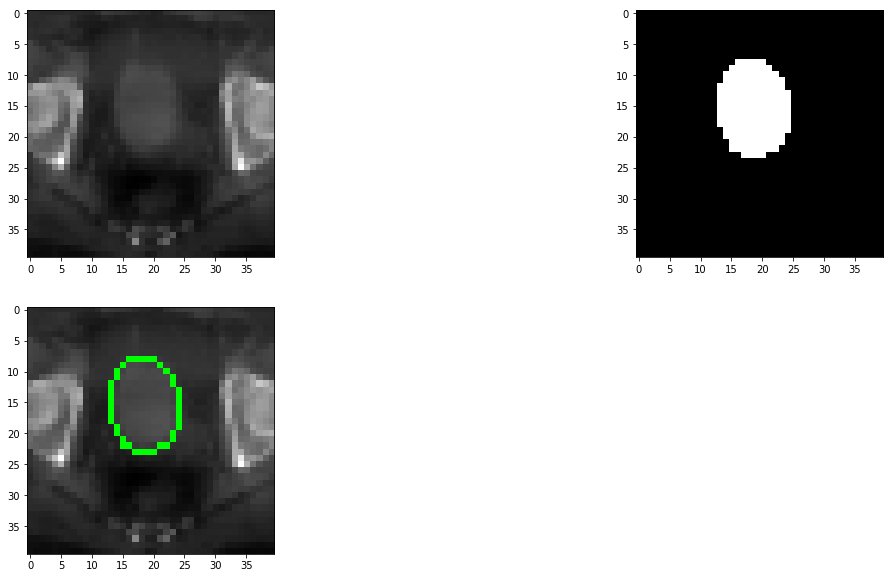

In [23]:
import imageio
import cv2
from scipy.misc import toimage, imsave
from PIL import Image

src_dir = '/DATA/public/bladder_40_40_32'

image = np.load(src_dir + '/cbct_test_1-image.npy')
mask = np.load(src_dir + '/cbct_test_1-mask.npy')

slice_num = 16
organ_num = 0
plt.figure(figsize=(20,10), frameon=False)

# ------- PRINT ORIGINAL CBCT IMAGE -------------------
plt.subplot(2,2,1)
plt.imshow(image[:,:,slice_num], cmap='gray')

# ------- PRINT ORIGINAL CBCT MASK -------------------
plt.subplot(2,2,2)
plt.imshow(mask[:,:,slice_num], cmap='gray')

# ------- OVERLAPPED ORIGINALS CBCT -------------------
# Load the image and convert it to grayscale:
image_original = cv2.imread("cbct_image.png")
image = cv2.imread("cbct_mask.png")
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply cv2.threshold() to get a binary image
ret, thresh = cv2.threshold(gray_image, 50, 255, cv2.THRESH_BINARY)

# Find contours:
im, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Draw contours:
cv2.drawContours(image_original, contours, 0, (0, 255, 0), 1)

# Show image:
plt.subplot(2,2,3)
plt.imshow(image_original)

# ------- OVERLAP PREDICTED SEGMENTATION MASK -------------------

